# UMAP embeddings for the monthly data comments from subreddits

# IMPORT MODULES

In [1]:
#import json
import os
#from google.colab import drive
from tqdm.notebook import tqdm
import pickle
from collections import Counter
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from scipy import spatial

import umap
import matplotlib.pyplot as plt

# import torch
# from sentence_transformers import SentenceTransformer, util
#from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# from sklearn.cluster import KMeans
# from sklearn.cluster import OPTICS
# import seaborn as sns

# TECHNICAL FUNCTIONS

In [2]:
def get_date_range(month_start, year_start, month_end, year_end):
    from itertools import cycle
    month_range = list(range(1,13))
    cycle_month_range = cycle(month_range)
    while True:
        current_month = next(cycle_month_range)
        if current_month == month_start:
            break
    date_tuples = []
    year = year_start
    while True:
        date_tuples.append((current_month, year))
        if year == year_end and current_month == month_end:
            break
        current_month = next(cycle_month_range)
        if current_month == 1:
            year += 1
    return date_tuples

# UPLOAD DATA

In [3]:
# google_drive_path = "./"
comptech_opinion_analizer_path = "./"

In [4]:
# UPLOAD THE DATA

data_dir = os.path.join(comptech_opinion_analizer_path, "embeddings_bert/")
data_files = [f for f in os.listdir(data_dir) if "pickle" in f]

entity = "Trump"
entity_data_files = sorted([f for f in data_files if entity in f])

df_vecs = pd.DataFrame()
for f in tqdm(entity_data_files):
    data_path = os.path.join(data_dir, f)
    df_vecs = df_vecs.append(pickle.load(open(data_path, "rb")))

# Show the timeline of comment counts



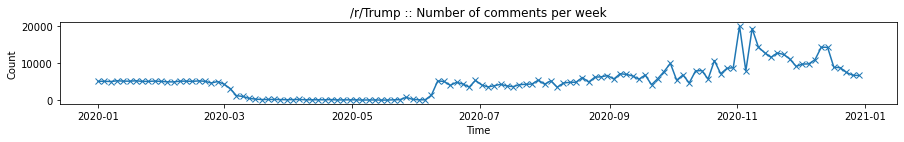

In [5]:
created_list = sorted(df_vecs.created_utc.to_list())
b_width = 3600*24*3 # weekly
bins = np.arange(min(created_list), max(created_list) + 1, b_width)
hist, bins = np.histogram(created_list, bins = bins)
dt_bins = [datetime.fromtimestamp(t) for t in bins[:-1]]

plt.figure(figsize=(15,1.5))
plt.title(f"/r/{entity} :: Number of comments per week")
plt.plot(dt_bins, hist, marker = "x")
plt.xlabel("Time")
plt.ylabel("Count")
plt.show()

# TSNE EMBEDDING OF COMMENTS

In [6]:
# ADD FOLDER
# colab_notebooks_path = os.path.join(google_drive_path, "Colab Notebooks/opinion_analyzer/")
umap_embedding_dir = os.path.join(comptech_opinion_analizer_path, "umap_embeddings")
os.makedirs(umap_embedding_dir, exist_ok = True)

In [13]:
# DIMENSIONALITY REDUCTION FOR ALL MONTHLY DATA
date_range = get_date_range(1, 2020, 1, 2021)
min_dist = 0.001
for my_start, my_end in tqdm(list(zip(date_range, date_range[1:]))):
    # PREPARATIONS
    dt_start = datetime(my_start[1], my_start[0], 1)
    dt_end = datetime(my_end[1], my_end[0], 1)

    month_str = dt_start.strftime("%b %Y")
    t_start, t_end = dt_start.timestamp(), dt_end.timestamp()

    month_vecs_df = df_vecs[(t_start < df_vecs.created_utc ) & (df_vecs.created_utc < t_end)]

    month_embeddings = month_vecs_df.embedding.to_list()
    month_labels = month_vecs_df.body.to_list()
    month_ids = month_vecs_df.link_id.to_list()
    print(f"Month labels {len(month_labels)}")
    
    # TSNE 
    embedder = umap.UMAP(min_dist = min_dist, metric = "cosine")
    month_embeddings_2d = embedder.fit_transform(month_embeddings)
    
    # OUTPUT 
    out_file = f"umap_embedding_2d_{entity}_{my_start[0]}_{my_start[1]}_min_dist_{round(min_dist, 2)}.pickle"
    out_path = os.path.join(umap_embedding_dir, out_file)
    out_pack = (month_ids, month_labels, month_embeddings_2d)
    pickle.dump(out_pack, open(out_path, "wb"))

Month labels 53041
Month labels 48727
Month labels 11409
Month labels 1336
Month labels 1717
Month labels 32262
Month labels 43540
Month labels 52872
Month labels 65871
Month labels 75946
Month labels 131677
Month labels 100439



# Visualisation of comments each month

In [9]:
target_month = 1

dt_start = datetime(2020, target_month, 1)
dt_end = datetime(2020, target_month+1, 1)

dt_str = dt_start.strftime("%b %Y")
dt_month = int(dt_start.strftime("%m"))
dt_year = int(dt_start.strftime("%Y"))

t_start, t_end = dt_start.timestamp(), dt_end.timestamp()

month_vecs_df = df_vecs[(t_start < df_vecs.created_utc ) & (df_vecs.created_utc < t_end)]

In [10]:
min_dist = 0.1
embedding_file = f"umap_embedding_2d_{entity}_{dt_month}_{dt_year}_min_dist_{round(min_dist, 2)}.pickle"
embedding_path = os.path.join(umap_embedding_dir, embedding_file)
(month_ids, month_labels, month_embeddings_2d) = pickle.load(open(embedding_path, "rb"))

In [11]:
month_labels_short = [s[:60]+"..." if len(s)>60 else s for s in month_labels]
len(month_labels_short)

53041

In [ ]:
# VISUALISATION
import plotly.graph_objects as go

marker_style = dict(color='lightblue', size=6,  line=dict(color='black', width = 0.5))

X, Y = zip(*month_embeddings_2d)
scatter_gl = go.Scattergl(x = X, y = Y, hovertext = month_labels_short, mode='markers', marker= marker_style)

fig = go.Figure(data = scatter_gl)
fig.update_layout(width=1000, height=700, plot_bgcolor = "white", margin=dict(l=10, r=10, t=30, b=10), 
                  title=f"UMAP comments /r/{entity} :: period {dt_str}")
fig.show()